In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf

In [7]:
train_dir =r"C:\Users\thesh\Downloads\archive (1) 2\chest_xray\train"
test_dir = r"C:\Users\thesh\Downloads\archive (1) 2\chest_xray\test"
val_dir = r'C:\Users\thesh\Downloads\archive (1) 2\chest_xray\val'



In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

Creating Data Generators

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [8]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Building the Model

In [9]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 37s 4us/step


In [10]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [11]:
EPOCHS = 50

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50


c:\Users\thesh\miniconda3\envs\ml_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 991ms/step - accuracy: 0.8900 - auc: 0.9127 - loss: 0.3241 - val_accuracy: 0.8750 - val_auc: 0.9922 - val_loss: 0.4678
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 945ms/step - accuracy: 0.9556 - auc: 0.9878 - loss: 0.1194 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2403
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9538 - auc: 0.9911 - loss: 0.1041 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.3959
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9585 - auc: 0.9919 - loss: 0.1012 - val_accuracy: 0.9375 - val_auc: 0.9688 - val_loss: 0.2754
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9590 - auc: 0.9928 - loss: 0.0920 - val_accuracy: 0.7500 - val_auc: 0.9844 - val_loss: 0.5953


Result

In [13]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int64))

cm = confusion_matrix(true_labels, pred_labels)

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 835ms/step


In [14]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

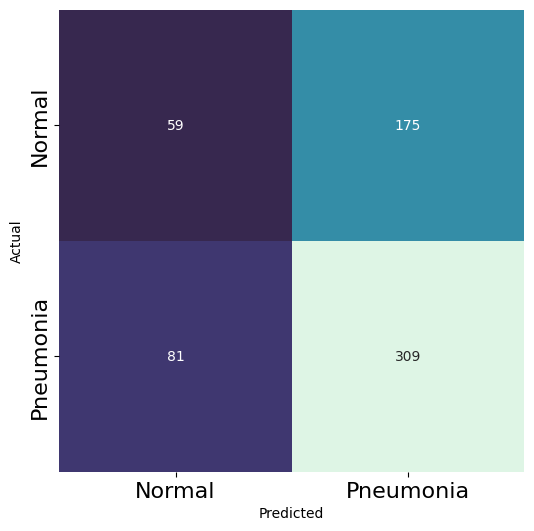

In [15]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [16]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [17]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [18]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.83
AUC: 0.95
Precision: 0.64
Recall: 0.79
